In [3]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
from DLScommonTools import *
import os
import pickle as pkl
from scipy import interpolate
import scipy as sp
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

# Overview
This notebook gives an example calculation and visualisation of detachment front location sensitivity, i.e. how fast will the front move through different regions of the domain depending on the magnetic topology. Front movement is proportional to the fractional B field gradient: the sharper the gradient as a proportion of the B field at that point (see Cowley 2022 for more details). This means the sharper the gradient and the lower the B field, the slower the front movement.

# Read and visualise equilibrium
- SPR38 inner and outer, visualised.

In [4]:
eqb = file_read("eqb_store.pkl")
data = eqb["SPR38"] # Pick design to use for study

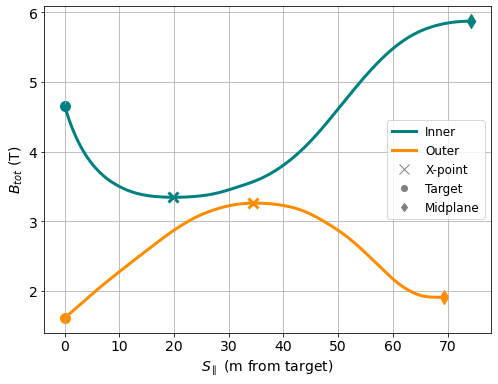

In [5]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

# Run basic density scan on both the inner and the outer

## Set DLS defaults

In [7]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}


## Run

In [8]:
cvar = "density"
design = "SPR38"
side = "ou"

store = dict()

for side in ["ou", "iu"]:
    d = eqb[design][side].copy() # Load in single profile into dictionary "d"
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5) # Solve at these parallel positions

    if side == "iu":
        constants["qpllu0"] = constants_default["qpllu0"] * 0.1 # Reduce power to 10% for the inner divertor to account for power sharing.

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar)
    
    store[side] = copy.deepcopy(results)


Solving...0...150...258...321...340...Complete in 11.5 seconds
Solving...0...55...84...96...104...Complete in 12.8 seconds


# Calculate detachment sensitivity

## Function to find detachment band
- The detachment band visualises the extent of the spatial movement of the front in response to a fluctuation.
- The centre of the band is the starting position (arbitrary), while its extents correspond to the positions due to a positive and negative fluctuation in the chosen control variable.
- A lower band is better, because it means the front moves less and is more resistant to fluctuations.

In [26]:
def make_window_band(d, o, spol_middle, size = 0.05):
    # Make band based on topology dictionary (d) and results dictionary (o)
    # and a desired S poloidal location of the band centre (spol_middle)
    # as well as band size as a fraction (default +/-5%)
    
    crel = np.array(o["crel"])
    splot = np.array(o["Splot"])
    spolplot = np.array(o["SpolPlot"])
    Btot = d["Btot"]
    Btot_grad = np.gradient(Btot)

    c_grid = np.linspace(crel[0], crel[-1], 1000)

    # Need continuous functions for the front locations and corresponding control variables.
    spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 3)
    spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 3)
    crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 3)

    c_middle = crel_from_spol(spol_middle)
    
    # Band control variable for middle and both ends.
    band = dict()
    band["C"] = [None] * 3
    band["C"][0] = c_middle * (1-size)
    band["C"][1] = c_middle
    band["C"][2] = c_middle * (1+size)

    # The dictionary "band" contains several parameters. Each parameter contains a list of three 
    # values corresponding to the three points of the band. In this way band["Btot"] has a list of the
    # total B values across the band.
    for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
        band[param] = np.array([float]*3)

    for i in range(3):
        band["Spar"][i] = spar_from_crel(band["C"][i])    
        band["Spol"][i] = spol_from_crel(band["C"][i])
        band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
        band["R"][i] = d["R"][band["index"][i]]
        band["Z"][i] = d["Z"][band["index"][i]]
        band["Btot"][i] = d["Btot"][band["index"][i]]
        
    band["width_pol"] = band["Spol"][2] - band["Spol"][0] # Band width in poloidal
    band["width_par"] = band["Spar"][2] - band["Spar"][0] # Band width in parallel
    band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
    band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

    return band


In [21]:
interpolate.UnivariateSpline(o["crel"], o["splot"], k= 3)

## Continuous plot of band widths
- Take space between the X-point and the target
- Exclude the lower 10% and upper 20% as regions too close to reattachment or front escape
- Calculate detachment band widths at each point
- Exclude bands whose ends are in the excluded regions near the target or near divertor

Plots
- LHS: band width. Lower = better = less sensitive front.
- RHS: B field profile. 

Text(0.5, 1.0, 'B field from target to X-point')

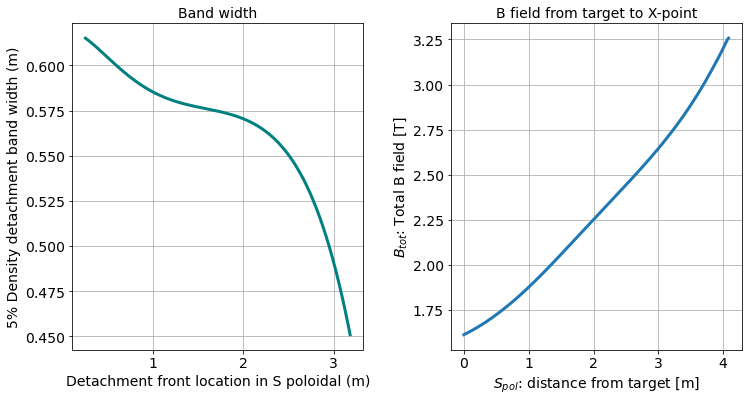

In [37]:
d = eqb["SPR38"]["ou"]
o = store["ou"]


Xpoint = d["Xpoint"]
Spolx = d["Spol"][Xpoint]
Spol = d["Spol"]

k = 0 # Y

Spol_lims = [Spolx*0.1, Spolx*0.8]
widths = []
Btot_avg = []
Btot_grad_avg = []

for s in Spol[:Xpoint]:

    band = make_window_band(d,o,s)
    if \
    band["Spol"][0] < Spol_lims[0] or \
    band["Spol"][2] > Spol_lims[1] or \
    band["width_pol"] < 0:
        widths.append(np.nan)
        Btot_avg.append(np.nan)
        Btot_grad_avg.append(np.nan)
    else:
        widths.append(band["width_pol"])
        Btot_avg.append(band["Btot_avg"])
        Btot_grad_avg.append(band["Btot_grad_avg"])        

fig, axes = plt.subplots(1,2, figsize = (12,6))
fig.subplots_adjust(wspace=0.2)

ax = axes[0]
ax.plot(Spol[:Xpoint], widths, color = colors[0])
ax.set_xlabel("Detachment front location in S poloidal (m)"); ax.set_ylabel("5% Density detachment band width (m)")
ax.set_title("Band width")

ax = axes[1]
ax.plot(Spol[:Xpoint], d["Btot"][:Xpoint])
ax.set_xlabel("$S_{pol}$: distance from target [m]"); ax.set_ylabel("$B_{tot}$: Total B field [T]")
ax.set_title("B field from target to X-point")

## Plot of a single band
- Plot a band at a given location (below plot is at 3m).

(-0.5, 5.0)

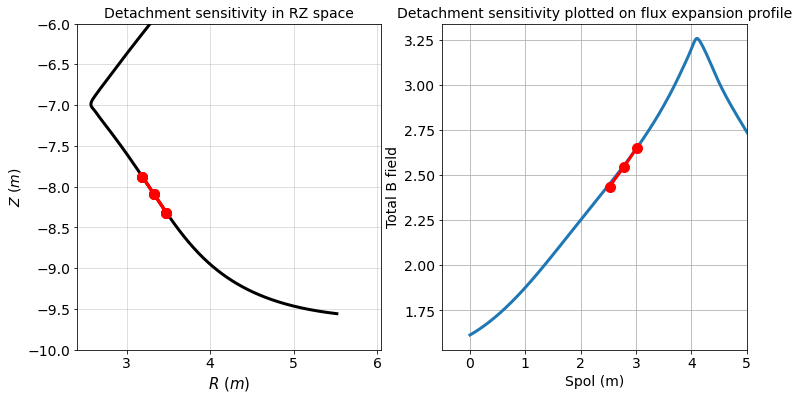

In [45]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
k = 6
d = eqb["SPR38"]["ou"]
o = store["ou"]

band = make_window_band(d, o, 3) # Make band at 3m

ax = axes[0]
ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-10, -6)
ax.grid(alpha = 0.5)
ax.set_title("Detachment sensitivity in RZ space")
color = "red"
for point in range(3):
    ax.plot(band["R"], band["Z"]*-1, markersize = 10, marker = "o", linewidth = 3, color = color)

ax = axes[1]
ax.plot(d["Spol"], d["Btot"]); ax.plot(band["Spol"], band["Btot"], marker = "o", color = color, markersize = 10, linewidth = 3); ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")
ax.set_title("Detachment sensitivity plotted on flux expansion profile")
ax.set_xlim(-0.5,5)